In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import numpy as np
import pandas as pd

sys.path.append('../..')
import project
import project.validation
from project.core import utils

utils.set_verbose(False)
utils.log('hello, world')

In [75]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
len(ds.subjects())

12288

# Stage 1 - metadata validation

In [4]:
subjects = list(ds.subjects())
variant = 'TEST'

rows = []
for ex in tqdm.tqdm(list(ds.examples(subjects, variant))):
    rows.append(project.validation.validate_example(ex, metadata=True))

m = pd.DataFrame(rows)

NameError: name 'tqdm' is not defined

# Stage 2 - path validation

In [37]:
subjects = list(m[m.valid].subject)

row = []
for ex in tqdm.tqdm(list(ds.examples(subjects, variant))):
    rows.append(project.validation.validate_example(ex, paths=True))

p = pd.DataFrame(rows)

100%|██████████| 9260/9260 [27:19<00:00,  5.65it/s]  


In [57]:
df = m.merge(p, on='subject', how='inner')
df

,subject,metadata.category.set,metadata.category.len,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,metadata.dims.shape,metadata.dims.value,...,paths.source_mesh.fsize,paths.source_mesh.valid,paths.source_mesh.reasons,paths.source_mask.exists,paths.source_mask.fsize,paths.source_mask.valid,paths.source_mask.reasons,paths.valid,paths.reasons,paths.source_mask.exc
0,wss.100f39dce7690f59efb94709f30ce0d2,"{Chair, Recliner}",2.0,True,(),0.012947,True,(),"(3,)","[111.34567, 100.547745, 96.13275]",...,95717.0,True,(),True,56778.0,True,(),True,(),NaN
1,wss.101354f9d8dede686f7b08d9de913afe,"{Speaker, _Attributes}",2.0,True,(),0.013620,True,(),"(3,)","[43.43313, 60.591843, 32.17259]",...,242527.0,True,(),True,52106.0,True,(),True,(),NaN
2,wss.1018f01d42ae7fad52249d8432f6087e,{Sword},1.0,True,(),0.010424,True,(),"(3,)","[78.23693, 4.360932, 18.058533]",...,1342220.0,True,(),True,17187.0,True,(),True,(),NaN
3,wss.1022fe7dd03f6a4d4d5ad9f13ac9f4e7,"{Chair, OfficeChair}",2.0,True,(),0.017984,True,(),"(3,)","[60.366123, 98.00925, 66.79712]",...,12347930.0,True,(),True,39138.0,True,(),True,(),NaN
4,wss.1028b32dc1873c2afe26a3ac360dbd4,"{Chair, OfficeSideChair}",2.0,True,(),0.036115,True,(),"(3,)","[78.41001, 117.685616, 77.54468]",...,982656.0,True,(),True,30383.0,True,(),True,(),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9255,wss.738cebb6eab9151bd4a8d9e46acec1f4,"{Lamp, WallLamp}",2.0,True,(),0.084080,True,(),"(3,)","[51.64453, 84.50152, 37.83612]",...,3040648.0,True,(),True,38352.0,True,(),True,(),NaN
9256,wss.571a3c2cf4c509596cb5b29312d0feee,"{Lamp, WallLamp}",2.0,True,(),0.069445,True,(),"(3,)","[69.44497, 39.93086, 69.44497]",...,129195.0,True,(),True,39694.0,True,(),True,(),NaN
9257,wss.1a6a520652aa2244146fa8a09fad6c38,"{Lamp, WallLamp}",2.0,True,(),0.087170,True,(),"(3,)","[52.854767, 69.972565, 59.619797]",...,722372.0,True,(),True,87.0,False,"(failed to load,)",False,"(failed to load,)",operands could not be broadcast together with ...
9258,wss.4ab745d5e834afd23765349fd8e5584,{CellPhone},1.0,True,(),0.006164,True,(),"(3,)","[10.935303, 4.3760524, 23.863827]",...,7221305.0,True,(),True,21259.0,True,(),True,(),NaN


In [4]:
csv_path = '2025-10-28_validate.csv'
#df.to_csv(csv_path)

# Stage 3 - artifact validation

In [9]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [10]:
csv_path = '2025-10-28_validate.csv'
val = pd.read_csv(csv_path, index_col=0)
subjects = list(val.subject)
N = len(subjects)
N

9260

In [11]:
base_dir = '2025-10-29_validate'

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 6:00:00
set -eo pipefail

source ~/.bashrc
LP=$PROJECT/lung-project

module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/validate.py --dataset shapenet --data_root $LP/data/ShapeNetSem --output {output_path} --subject {subject}

'''
name_format = '{params_hash}'

grid = [{'subject': ','.join(subjects[i:i+100])} for i in range(0, N, 100)]
len(grid)

93

In [12]:
%autoreload
#jobs = ps.setup(base_dir, template, name_format, grid)
jobs = ps.load(base_dir)
jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,array_idx,last_live_at,state_source,finalized,finalized_at,error_line,output_exists,output_fsize,output_mtime
0,0103f8f8d5c25bf7,COMPLETED,3,35682706,v004,00:31:56,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98406.0,1.761725e+09
1,2c2a66a5b73cc06d,COMPLETED,3,35682707,v009,00:38:33,artifacts.binvox.clean.max ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.127aff49c9378499ae685ca100c909e8,wss.12811...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98248.0,1.761725e+09
2,b20663a8a1600460,COMPLETED,3,35682708,v012,00:45:15,artifacts.binvox.clean.thickness_p50 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.14e4cb9d8fd5c29f60467dddaf5cfe3f,wss.14e5d...",NaN,None,history,True,2025-10-30T00:45:10,None,True,99076.0,1.761726e+09
3,dfdacaf62ea4a0ad,COMPLETED,3,35682709,v019,01:54:57,artifacts.binvox.clean.min ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.1730e6c6a37f19abefae06b5b9950833,wss.1741b...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97882.0,1.761730e+09
4,c93edace8ae2f554,COMPLETED,3,35682710,v024,00:42:05,artifacts.binvox.clean.min ...,WARNING- 4 double-triangles have been removed....,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.198d36bcfacb1a7a4212ff51b27f0221,wss.19927...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97349.0,1.761725e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,f342d995ff0b8b40,COMPLETED,2,35682794,w010,00:39:43,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.ffcc57ea3101d18ece3df8a7477638c0,wss.ffcf0...",NaN,None,history,True,2025-10-30T00:45:10,None,True,104799.0,1.761728e+09
89,b4c4f77d0ea31b34,COMPLETED,3,35725543,v009,00:25:12,4 4 4 4 4 4 3 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.32dc55c3e945384dbc5e533ab711fd24,wss.33d2a...",NaN,2025-10-30T01:35:37,history,True,2025-10-30T02:22:15,None,True,110296.0,1.761805e+09
90,bcdb4e7218d14874,COMPLETED,2,35682796,v020,00:38:49,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.66f56dc9a4751bded9651cd1d591d64d,wss.6730f...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109315.0,1.761728e+09
91,5c023e2f832d4dcf,COMPLETED,2,35682797,w005,00:17:15,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.a47cd8002c2f342b14513156cf2b8d0d,wss.a4d44...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109598.0,1.761727e+09


In [13]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs = ps.collect(jobs)
jobs #.loc[sel]

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,array_idx,last_live_at,state_source,finalized,finalized_at,error_line,output_exists,output_fsize,output_mtime
0,0103f8f8d5c25bf7,COMPLETED,3,35682706,v004,00:31:56,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98406,1.761725e+09
1,2c2a66a5b73cc06d,COMPLETED,3,35682707,v009,00:38:33,artifacts.binvox.clean.max ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.127aff49c9378499ae685ca100c909e8,wss.12811...",NaN,None,history,True,2025-10-30T00:45:10,None,True,98248,1.761725e+09
2,b20663a8a1600460,COMPLETED,3,35682708,v012,00:45:15,artifacts.binvox.clean.thickness_p50 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.14e4cb9d8fd5c29f60467dddaf5cfe3f,wss.14e5d...",NaN,None,history,True,2025-10-30T00:45:10,None,True,99076,1.761726e+09
3,dfdacaf62ea4a0ad,COMPLETED,3,35682709,v019,01:54:57,artifacts.binvox.clean.min ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.1730e6c6a37f19abefae06b5b9950833,wss.1741b...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97882,1.761730e+09
4,c93edace8ae2f554,COMPLETED,3,35682710,v024,00:42:05,artifacts.binvox.clean.min ...,WARNING- 4 double-triangles have been removed....,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.198d36bcfacb1a7a4212ff51b27f0221,wss.19927...",NaN,None,history,True,2025-10-30T00:45:10,None,True,97349,1.761725e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,f342d995ff0b8b40,COMPLETED,2,35682794,w010,00:39:43,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.ffcc57ea3101d18ece3df8a7477638c0,wss.ffcf0...",NaN,None,history,True,2025-10-30T00:45:10,None,True,104799,1.761728e+09
89,b4c4f77d0ea31b34,COMPLETED,3,35725543,v009,00:25:12,4 4 4 4 4 4 3 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.32dc55c3e945384dbc5e533ab711fd24,wss.33d2a...",NaN,2025-10-30T01:35:37,history,True,2025-10-30T02:22:15,None,True,110296,1.761805e+09
90,bcdb4e7218d14874,COMPLETED,2,35682796,v020,00:38:49,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.66f56dc9a4751bded9651cd1d591d64d,wss.6730f...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109315,1.761728e+09
91,5c023e2f832d4dcf,COMPLETED,2,35682797,w005,00:17:15,artifacts.binvox.clean.thickness_p5 ...,WARNING- Some cuts were necessary to cope with...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,"wss.a47cd8002c2f342b14513156cf2b8d0d,wss.a4d44...",NaN,None,history,True,2025-10-30T00:45:10,None,True,109598,1.761727e+09


In [14]:
jobs.iloc[89]

job_name                                           b4c4f77d0ea31b34
job_state                                                 COMPLETED
n_submits                                                         3
job_id                                                     35725543
node_id                                                        v009
runtime                                                    00:25:12
stdout                 4     4     4     4     4     4     3    ...
stderr            WARNING- Some cuts were necessary to cope with...
base_dir          /ocean/projects/asc170022p/mtragoza/lung-proje...
work_dir          /ocean/projects/asc170022p/mtragoza/lung-proje...
script_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
output_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
log_dir           /ocean/projects/asc170022p/mtragoza/lung-proje...
stdout_path       /ocean/projects/asc170022p/mtragoza/lung-proje...
stderr_path       /ocean/projects/asc170022p/mtr

In [18]:
sel = (jobs['job_state'] == 'FAILED')
jobs.loc[sel, 'job_id'] #= pd.NA # flag to resubmit
jobs.loc[jobs['job_id'].isna()]

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.subject,array_idx,last_live_at,state_source,finalized,finalized_at,error_line,output_exists,output_fsize,output_mtime


In [20]:
ps.set_verbose(True)
jobs = ps.submit(jobs)

no jobs require submit


In [21]:
df = ps.outputs(jobs, skip_errors=False)
df

,subject,metadata.category.set,metadata.category.len,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,metadata.dims.shape,metadata.dims.value,...,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,params_hash,params.subject
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Chair', 'Recliner'}",2,True,(),0.012947,True,(),"(3,)",[111.34567 100.547745 96.13275 ],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35682706,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
1,wss.101354f9d8dede686f7b08d9de913afe,"{'_Attributes', 'Speaker'}",2,True,(),0.013620,True,(),"(3,)",[43.43313 60.591843 32.17259 ],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35682706,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
2,wss.1018f01d42ae7fad52249d8432f6087e,{'Sword'},1,True,(),0.010424,True,(),"(3,)",[78.23693 4.360932 18.058533],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35682706,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
3,wss.1022fe7dd03f6a4d4d5ad9f13ac9f4e7,"{'Chair', 'OfficeChair'}",2,True,(),0.017984,True,(),"(3,)",[60.366123 98.00925 66.79712 ],...,"('single geometry',)",False,"('single geometry',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35682706,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
4,wss.1028b32dc1873c2afe26a3ac360dbd4,"{'Chair', 'OfficeSideChair'}",2,True,(),0.036115,True,(),"(3,)",[ 78.41001 117.685616 77.54468 ],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35682706,0103f8f8d5c25bf7,"wss.100f39dce7690f59efb94709f30ce0d2,wss.10135..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9255,wss.738cebb6eab9151bd4a8d9e46acec1f4,"{'WallLamp', 'Lamp'}",2,True,(),0.084080,True,(),"(3,)",[51.64453 84.50152 37.83612],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35725544,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9256,wss.571a3c2cf4c509596cb5b29312d0feee,"{'WallLamp', 'Lamp'}",2,True,(),0.069445,True,(),"(3,)",[69.44497 39.93086 69.44497],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35725544,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9257,wss.1a6a520652aa2244146fa8a09fad6c38,"{'WallLamp', 'Lamp'}",2,True,(),0.087170,True,(),"(3,)",[52.854767 69.972565 59.619797],...,"('missing binvox',)",False,"('failed to load', 'missing binvox')",NaN,operands could not be broadcast together with ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35725544,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."
9258,wss.4ab745d5e834afd23765349fd8e5584,{'CellPhone'},1,True,(),0.006164,True,(),"(3,)",[10.935303 4.3760524 23.863827 ],...,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35725544,8786de37533664e5,"wss.eddefff6f7f36ac333b5f1127fe70646,wss.ee4a8..."


In [22]:
meta_cols = [c for c in df.columns if c.startswith('metadata')]
path_cols = [c for c in df.columns if c.startswith('paths')]
art_cols = [c for c in df.columns if c.startswith('artifacts')]
[c for c in df.columns if c not in set(meta_cols + path_cols + art_cols)]

['subject',
 'valid',
 'reasons',
 'source_path',
 'job_name',
 'job_id',
 'params_hash',
 'params.subject']

In [45]:
def parse_vector(x):
    import numpy as np
    assert x[0] == '[' and x[-1] == ']'
    parts = x[1:-1].split()
    return np.array([float(v) for v in parts])

def rel_error(a, b):
    from numpy.linalg import norm
    return norm(a - b) / norm(b)

errors = []
for i, row in df[m].iterrows():
    subj = row['subject']
    dims = parse_vector(row['metadata.dims_by_unit'])
    extent = parse_vector(row['artifacts.scene.mesh.extent'])
    error = rel_error(dims[[0,2,1]] / 100., extent)
    errors.append(error)

df.loc[m, 'dims_error'] = errors

In [82]:
CATEGORY_BLACKLIST = {'Room', 'Courtyard'}

def check_category_set(x):
    import ast
    return not (ast.literal_eval(x) & CATEGORY_BLACKLIST)

m = (
    (df['artifacts.scene.geometries'] > 1) &
    (df['artifacts.scene.geometries'] <= 10) &
    (df['artifacts.scene.mesh.vertices'] > 100) &
    (df['artifacts.scene.mesh.vertices'] <= 500000) &
    (df['artifacts.scene.repair.is_watertight']) &
    (df['artifacts.scene.repair.volume'] > 0 ) &
    (df['artifacts.scene.repair.convexity'] > 0.5) &
    (df['artifacts.binvox.array.nonzero'] > 32**3) &
    (df['artifacts.binvox.clean.thickness_p50'] > 5) &
    (df['metadata.category.set']).map(check_category_set) &
    (df['dims_error'] < 1e-2) # dims are interpretable
)
print(m.sum(), m.mean() * 100, df[m].valid.mean() * 100)

df[m].groupby(['valid'], sort=False)[art_cols].describe().stack().T

1122 12.116630669546437 100.0


/var/tmp/ipykernel_47910/2200489668.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df[m].groupby(['valid'], sort=False)[art_cols].describe().stack().T


valid                                       True                              \
                                           count          mean           std   
artifacts.scene.geometries                1122.0  4.352050e+00  2.162436e+00   
artifacts.scene.mesh.vertices             1122.0  1.988545e+04  4.392673e+04   
artifacts.scene.mesh.faces                1122.0  6.628483e+03  1.464224e+04   
artifacts.scene.mesh.boundary_edges       1122.0  1.473232e+04  1.971459e+04   
artifacts.scene.mesh.interior_edges       1122.0  1.396758e+03  7.377276e+03   
artifacts.scene.mesh.nonmanifold_edges    1122.0  6.250472e+02  6.550928e+03   
artifacts.scene.mesh.euler_number         1122.0  6.628483e+03  1.464224e+04   
artifacts.scene.mesh.surface_area         1122.0  2.636744e+07  8.194569e+08   
artifacts.scene.mesh.volume               1122.0  1.016579e+11  3.404429e+12   
artifacts.scene.mesh.convexity             621.0  5.150460e-01  1.094876e+00   
artifacts.scene.repair.vertices           1122.0  5.844652e+02  1.018069e+03   
artifacts.scene.repair.faces              1122.0  1.165209e+03  2.036112e+03   
artifacts.scene.repair.boundary_edges     1122.0  0.000000e+00  0.000000e+00   
artifacts.scene.repair.interior_edges     1122.0  1.747813e+03  3.054167e+03   
artifacts.scene.repair.nonmanifold_edges  1122.0  0.000000e+00  0.000000e+00   
artifacts.scene.repair.euler_number       1122.0  1.860963e+00  6.338012e-01   
artifacts.scene.repair.surface_area       1122.0  4.937781e+06  1.379012e+08   
artifacts.scene.repair.volume             1122.0  2.187637e+10  7.085272e+11   
artifacts.scene.repair.convexity          1122.0  8.786978e-01  1.408244e-01   
artifacts.binvox.scale                    1122.0  1.541681e+01  1.036292e+02   
artifacts.binvox.array.ndim               1122.0  3.000000e+00  0.000000e+00   
artifacts.binvox.array.min                1122.0  1.782531e-03  4.220120e-02   
artifacts.binvox.array.max                1122.0  1.000000e+00  0.000000e+00   
artifacts.binvox.array.sum                1122.0  5.013694e+05  3.382076e+05   
artifacts.binvox.array.mean               1122.0  2.390716e-01  1.612699e-01   
artifacts.binvox.array.nonzero            1122.0  5.013694e+05  3.382076e+05   
artifacts.binvox.array.nans               1122.0  0.000000e+00  0.000000e+00   
artifacts.binvox.array.components         1122.0  1.502852e+01  8.976147e+01   
artifacts.binvox.array.thickness_p5       1122.0  1.259115e+00  2.442782e+00   
artifacts.binvox.array.thickness_p50      1122.0  8.458070e+00  5.886019e+00   
artifacts.binvox.array.thickness_p95      1122.0  2.140688e+01  1.024820e+01   
artifacts.binvox.array.area_p5            1122.0  9.137584e-02  1.439009e-01   
artifacts.binvox.array.area_p50           1122.0  2.779393e-01  1.834299e-01   
artifacts.binvox.array.area_p95           1122.0  5.662366e-01  1.962845e-01   
artifacts.binvox.clean.ndim               1122.0  3.000000e+00  0.000000e+00   
artifacts.binvox.clean.min                1122.0  1.782531e-03  4.220120e-02   
artifacts.binvox.clean.max                1122.0  1.000000e+00  0.000000e+00   
artifacts.binvox.clean.sum                1122.0  4.996490e+05  3.391278e+05   
artifacts.binvox.clean.mean               1122.0  2.382512e-01  1.617088e-01   
artifacts.binvox.clean.nonzero            1122.0  4.996490e+05  3.391278e+05   
artifacts.binvox.clean.nans               1122.0  0.000000e+00  0.000000e+00   
artifacts.binvox.clean.components         1122.0  1.000000e+00  0.000000e+00   
artifacts.binvox.clean.thickness_p5       1122.0  1.263293e+00  2.443727e+00   
artifacts.binvox.clean.thickness_p50      1122.0  9.323638e+00  6.378595e+00   
artifacts.binvox.clean.thickness_p95      1122.0  2.483682e+01  1.212757e+01   
artifacts.binvox.clean.area_p5            1122.0  1.122272e-01  1.501608e-01   
artifacts.binvox.clean.area_p50           1122.0  2.803662e-01  1.839217e-01   
artifacts.binvox.clean.area_p95           1122.0  5.663866e-01  1.974649e-01   


In [83]:
 df.loc[m, ['subject', 'metadata.category.set', 'artifacts.scene.repair.convexity', 'artifacts.binvox.array.components']]

,subject,metadata.category.set,artifacts.scene.repair.convexity,artifacts.binvox.array.components
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Chair', 'Recliner'}",0.943700,5.0
1,wss.101354f9d8dede686f7b08d9de913afe,"{'_Attributes', 'Speaker'}",0.974915,4.0
5,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},0.940698,5.0
6,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Computer', 'Desktop'}",0.953723,1.0
47,wss.111cb08c8121b8411749672386e0b711,{'Chair'},0.929372,130.0
...,...,...,...,...
9205,wss.f201949c0dda436f96d5fa1ee6ada8d1,{'Desk'},0.917675,1.0
9223,wss.f9244dc91aebf77ba4c322790a683350,"{'Cup', '_SceneGalleryModels', '_StanfordScene...",0.647593,5.0
9241,wss.c13ce3bd7153ea262388b9322a31a5,{'CellPhone'},1.000000,2.0
9250,wss.b375f5b9102a97fecd187756f8df9a56,"{'CeilingLamp', '_StanfordSceneDBModels', 'Lamp'}",0.940832,2.0


In [84]:
%autoreload
examples = list(ds.examples(df.loc[m, 'subject'].tolist(), variant='TEST'))
len(examples)

1122

In [86]:
ex = examples[0]
utils.pprint(ex)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.100f39dce7690f59efb94709f30ce0d2'
├── variant:  'TEST'
├── paths:    dict(len=12)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/100f39dce7690f59efb94709f30ce0d2.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/100f39dce7690f59efb94709f30ce0d2.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/TEST/100f39dce7690f59efb94709f30ce0d2/masks/material.nii.gz')
|   ├── 'density_field': Posix

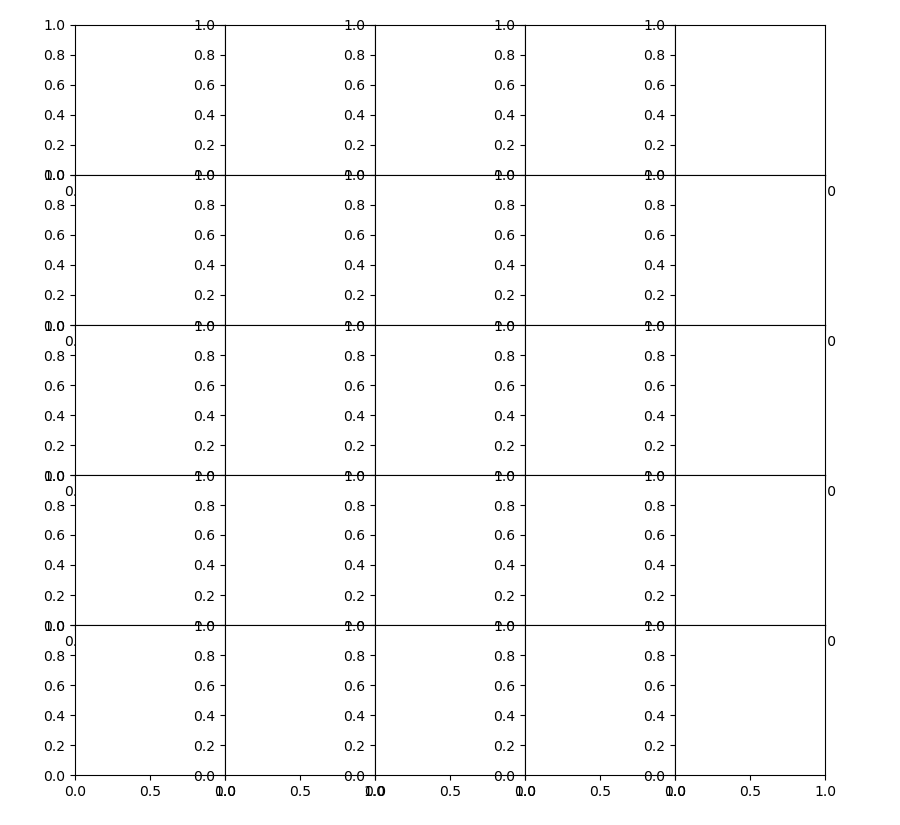

In [91]:
def show_thumbnails(examples, n_rows=5, n_cols=5):
    from project.visual.matplotlib import subplot_grid

    fig, axes = subplot_grid(
        n_rows, n_cols,
        ax_height=1.5,
        ax_width=1.5,
        spacing=(0., 0.), # hw
        padding=(0.75, 0.75, 0.5, 0.25), # lrbt
    )
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i,j]
            
            a = np.eye(10)
            ax.imshow(a, cmap='gray', extent=(0, W - 1, 0, H - 1))

        for j in range(j+1, n_cols):
            axes[i,j].axis('off')

    return fig

show_thumbnails(examples)